In [72]:
#####Gamma Regression model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

(array([7.0758e+04, 1.8458e+04, 6.0230e+03, 2.3930e+03, 1.0680e+03,
        5.6300e+02, 3.0900e+02, 1.7000e+02, 9.8000e+01, 6.4000e+01,
        3.9000e+01, 1.9000e+01, 1.1000e+01, 6.0000e+00, 5.0000e+00,
        5.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([3.99889069e-03, 3.52048833e+00, 7.03697777e+00, 1.05534672e+01,
        1.40699566e+01, 1.75864461e+01, 2.11029355e+01, 2.46194250e+01,
        2.81359144e+01, 3.16524038e+01, 3.51688933e+01, 3.86853827e+01,
        4.22018722e+01, 4.57183616e+01, 4.92348510e+01, 5.27513405e+01,
        5.62678299e+01, 5.97843194e+01, 6.33008088e+01, 6.68172982e+01,
        7.03337877e+01, 7.38502771e+01, 7.73667666e+01, 8.08832560e+01,
        8.43997454e+01, 8.79162349e+01]),
 <a list of 25 Patch objects>)

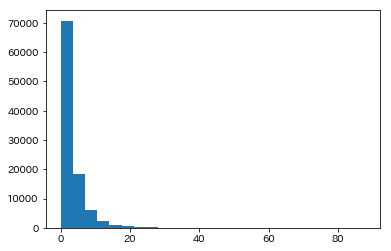

In [91]:
##データの生成
#データの設定
N = 100000
k = 10

#説明変数の生成
k1 = 3; k2 = 5; k3 = 5
x1 = np.array(np.random.random(N*k1)).reshape((N, k1))
x2 = np.zeros((N, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, N)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), N)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.concatenate((np.repeat(1, N)[:, np.newaxis], x1, x2, x3), axis=1)
k = x.shape[1]

#応答変数の生成
alpha = 2.0
beta = np.append(1.0, np.random.normal(0.0, 0.5, k-1))
thetat = np.append(alpha, beta)
Lambda = np.exp(np.dot(x, beta))
y = np.random.gamma(alpha, Lambda, N)
y_log = np.log(y)
plt.hist(y, bins=25)

In [92]:
##ガンマ回帰のパラメータを推定するための関数
#ガンマ回帰モデルの対数尤度
def loglike(theta, y, y_log, x, N):
    #パラメータの設定
    alpha = np.exp(theta[0])
    beta = theta[1:]
    
    #期待値の設定
    mu = np.dot(x, beta).reshape(-1)
    Lambda = np.exp(mu); inv_Lambda = 1/Lambda

    #対数尤度の和
    LL = np.sum(alpha*np.log(inv_Lambda) - scipy.special.loggamma(alpha) + (alpha-1)*y_log - inv_Lambda*y)
    return -LL

#ガンマ回帰の対数事後分布の微分関数
def dll(theta, y, y_log, x, N):
    #パラメータの設定
    alpha = np.exp(theta[0])
    beta = theta[1:]
    
    #期待値の設定
    mu = np.dot(x, beta).reshape(-1)
    Lambda = np.exp(mu); inv_Lambda = 1/Lambda

    #微分関数の和
    dlgamma1 = np.sum(np.log(inv_Lambda) - scipy.special.digamma(alpha) + y_log)
    dlgamma2 = np.sum((((alpha*(1/inv_Lambda)) - y) * -Lambda/np.power(Lambda, 2))[:, np.newaxis] * x, axis=0)
    dlgamma = np.append(dlgamma1, dlgamma2)
    return -dlgamma

In [95]:
##最尤法でパラメータを推定
#準ニュートン法で対数尤度を最大化
theta = np.append(0.0, np.append(1.0, np.random.normal(0, 0.25, k-1)))
res = optimize.minimize(loglike, theta, jac=dll, method="CG", args=(y, y_log, x, N), options={"disp": True})

#パラメータの推定結果
theta = res.x
LL = -res.fun
LLbest = -loglike(np.append(np.log(thetat[0]), thetat[1:]), y, y_log, x, N)
print(np.round(np.array([LL, LLbest]), 1))
print(np.round(np.append(np.exp(theta[0]), thetat[0]), 3))
print(np.round(np.vstack((theta[1:], thetat[1:, ])), 3))

         Current function value: 180682.204150
         Iterations: 77
         Function evaluations: 268
         Gradient evaluations: 255
[-180682.2 -180687.4]
[1.992 2.   ]
[[ 1.003  0.111 -0.704 -0.349  0.073  0.288  0.772 -0.887  0.376 -0.603
  -0.491 -0.707 -0.203]
 [ 1.     0.109 -0.714 -0.343  0.072  0.287  0.777 -0.888  0.373 -0.595
  -0.491 -0.698 -0.198]]


Text(0.5,1,'生成データの分布')

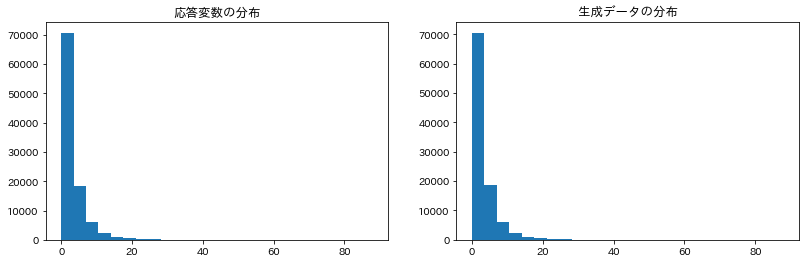

In [96]:
#推定結果を可視化
Lambda = np.exp(np.dot(x, theta[1:]))
y_hat = np.random.gamma(np.exp(theta[0]), Lambda, N)

#応答変数の可視化
fig = plt.figure(figsize=(13.5, 4.0))
ax = fig.add_subplot(1, 2, 1)
ax.hist(y, bins=25, range=[0.0, np.max(y)])
ax.set_title('応答変数の分布', fontsize=12.5)
ax = fig.add_subplot(1, 2, 2)
ax.hist(y_hat, bins=25, range=[0.0, np.max(y)])
ax.set_title('生成データの分布', fontsize=12.5)